## To do
First for one storm point:
* X Select values of lat, vmax, rmax for one storm from data.
* X Figure out how to run w_profile.py with example lat, vmax, rmax from Jupyter Notebooks.
* X Figure out how to evaluate on lat-lon grid.
* Figure out how to add in the asymmetry due to storm movement.

In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#!/usr/bin/env python
from __future__ import division
from builtins import str
from builtins import range
from past.utils import old_div
import numpy as np
import datetime
import pickle
from netCDF4 import Dataset
import sys
import matplotlib.pyplot as plt
from chaz import CLE15, utility
from pygplib import readbst
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
from scipy.interpolate import griddata
from pyproj import Proj, transform
from pygplib3 import landfall as ld
from wind_reconstruct.w_profile import W_profile # from Qidong
import math

In [3]:
# RETRIEVE WNP STORM INFORMATION
fileName = '/data2/clee/bttracks/Allstorms.ibtracs_all.v03r10.nc'
ibtracs = readbst.read_ibtracs(fileName, 'wnp')
ipoi = np.array([1925]) # index for storm Haiyan is 1925
n = 25 # pick one time point

# Load data from file
lon = ibtracs.lon[n, ipoi]
lat = ibtracs.lat[n, ipoi]
wspd = ibtracs.wspd[n, ipoi] # wind speed in knots
days = ibtracs.days[n, ipoi] # date in days
dist2land = ibtracs.dist2land[n, ipoi]
year = ibtracs.year[ipoi]

rmax = utility.knaff15(wspd, lat)  # km
rmax[np.where(rmax<0)] = 10 # 6-12-20: set places with radii less than 0 to 20 m to fix convergence


[10] wnp
(2071,)


/home/jbaldwin/lib/python/pygplib/readbst.py:174: RuntimeWarning: invalid value encountered in less
  lon[lon < 0] = lon[lon < 0]+360


Text(0.5, 0, 'Distance from Center of Storm [km]')

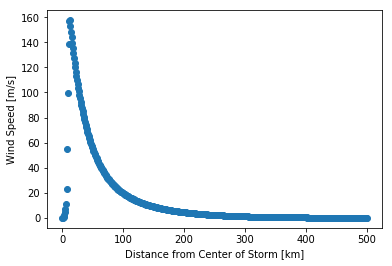

In [12]:
# Determine Willoughby Profile
radius_max = 500
radius_precision = 1

profile = W_profile(lat,rmax,wspd,radius_max, radius_precision)
radius = np.arange(0,radius_max + radius_precision, radius_precision)
plt.scatter(radius,profile)
plt.ylabel('Wind Speed [m/s]')
plt.xlabel('Distance from Center of Storm [km]')

In [28]:
# Create dict look-up table from Willoughby Profile

wspdlookup = dict(zip(radius, profile))

In [52]:
# Define x-y grid to put profile on
X = np.arange(-180,180.1,0.1)
Y = np.arange(-80,80.1,0.1)
X1, Y1 = np.meshgrid(X,Y)

In [86]:
# Center of storm = lat, lon
# Calculate distance between center point and each grid point
# adopted from: https://kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python

R = 6373.0 #radius of the Earth

# coordinates
#lat1 = radians(52.2296756)
#lon1 = radians(21.0122287)
#lat2 = radians(52.406374)
#lon2 = radians(16.9251681)

lat1 = math.radians(lat)
lon1 = math.radians(lon)
lat2 = np.radians(Y1)
lon2 = np.radians(X1)

# change in coordinates
dlon = lon2 - lon1
dlat = lat2 - lat1

# Haversine formula
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
distance = R * c


In [68]:
# Distance in integer form (will have to change if want precision higher than 1 km)
distance = distance.astype(int)

# Remap radii to windspeed
wspdmap = np.zeros(np.shape(distance))
for r in radius:
    wspdmap[np.where(distance == r)] = wspdlookup[r]

(10, 13)

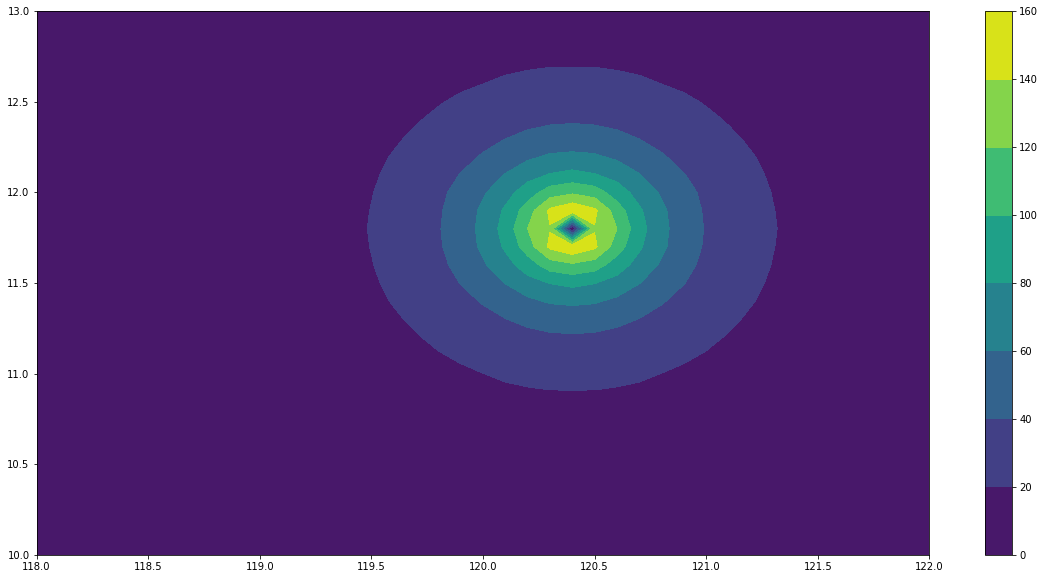

In [85]:
plt.figure(figsize=(20,10))
plt.contourf(X1,Y1,wspdmap)
plt.colorbar()
#plt.scatter(lon,lat,marker='x',color='r')
plt.xlim([118,122])
plt.ylim([10,13])

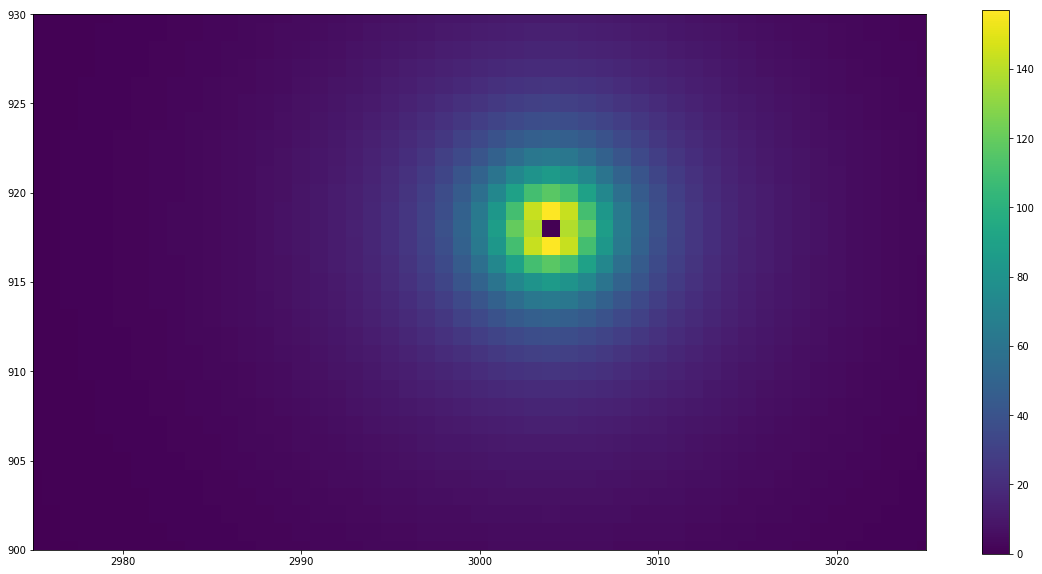

In [81]:
plt.figure(figsize=(20,10))
plt.imshow(wspdmap)
plt.ylim([900,930])
plt.xlim([2975,3025])
plt.colorbar()